#Loading data in dataframe

In [2]:
import os
import pandas as pd
import imagesize
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
from PIL import Image
from sklearn.preprocessing import LabelEncoder


In [3]:
from PIL.ImageFile import ImageFile

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
ImageFile.LOAD_TRUNCATED_IMAGES = True
print(device)
torch.cuda.get_device_name(0)
images_for_train = 5000

cuda:0


In [4]:
use_our_images = 0
our_images_path = "F:/OneDrive - Hochschule Karlsruhe/toShare/hierKommenDeineBilderRein"
data_path = "F:/OneDrive - Hochschule Karlsruhe/toShare/waste-classification/data"
#data_path = "C:/Storage/PA_datasets/garbageDataset"

image = []
labels = []
width = []
height = []

for i in range (1,3):
    if i == 2 and not use_our_images:
        break
    if i == 2:
        data_path = our_images_path
    for file in os.listdir(data_path):
        # if file == 'elektromuell':
        #     for c in os.listdir(os.path.join(data_path, file)):
        #         image.append(c)
        #         labels.append('elektromuell')
        #         w, h = imagesize.get(data_path + "/" + file + "/" + c)
        #         width.append(w), height.append(h)
        if file == 'glas':
            for c in os.listdir(os.path.join(data_path, file)):
                image.append(c)
                labels.append('glas')
                w, h = imagesize.get(data_path + "/" + file + "/" + c)
                width.append(w), height.append(h)
        if file == 'organic':
            for c in os.listdir(os.path.join(data_path, file)):
                image.append(c)
                labels.append('organic')
                w, h = imagesize.get(data_path + "/" + file + "/" + c)
                width.append(w), height.append(h)
        if file == 'paper':
            for c in os.listdir(os.path.join(data_path, file)):
                image.append(c)
                labels.append('paper')
                w, h = imagesize.get(data_path + "/" + file + "/" + c)
                width.append(w), height.append(h)
        if file == 'restmuell':
            for c in os.listdir(os.path.join(data_path, file)):
                image.append(c)
                labels.append('restmuell')
                w, h = imagesize.get(data_path + "/" + file + "/" + c)
                width.append(w), height.append(h)
        if file == 'wertstoff':
            for c in os.listdir(os.path.join(data_path, file)):
                image.append(c)
                labels.append('wertstoff')
                w, h = imagesize.get(data_path + "/" + file + "/" + c)
                width.append(w), height.append(h)

data = {'Images': image, 'labels': labels, 'width': width, 'height': height}
data = pd.DataFrame(data)
lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

In [5]:
data

,Images,labels,width,height,encoded_labels
0,glass (1000).jpg,glas,512,384,0
1,glass (1001).jpg,glas,512,384,0
2,glass (1002).jpg,glas,512,384,0
3,glass (1003).jpg,glas,512,384,0
4,glass (1004).jpg,glas,512,384,0
...,...,...,...,...,...
18223,wertstoff (9276).jpg,wertstoff,512,384,4
18224,wertstoff (94).jpg,wertstoff,500,500,4
18225,wertstoff (96).jpg,wertstoff,350,350,4
18226,wertstoff (98).jpg,wertstoff,850,850,4


<AxesSubplot:ylabel='count'>

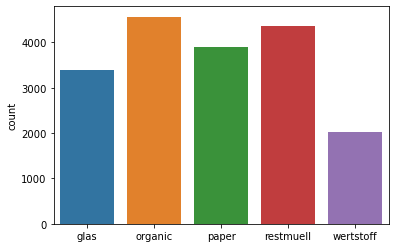

In [6]:
sns.countplot(x = labels)

<AxesSubplot:title={'center':'Width of images'}, xlabel='Waste-class', ylabel='Width'>

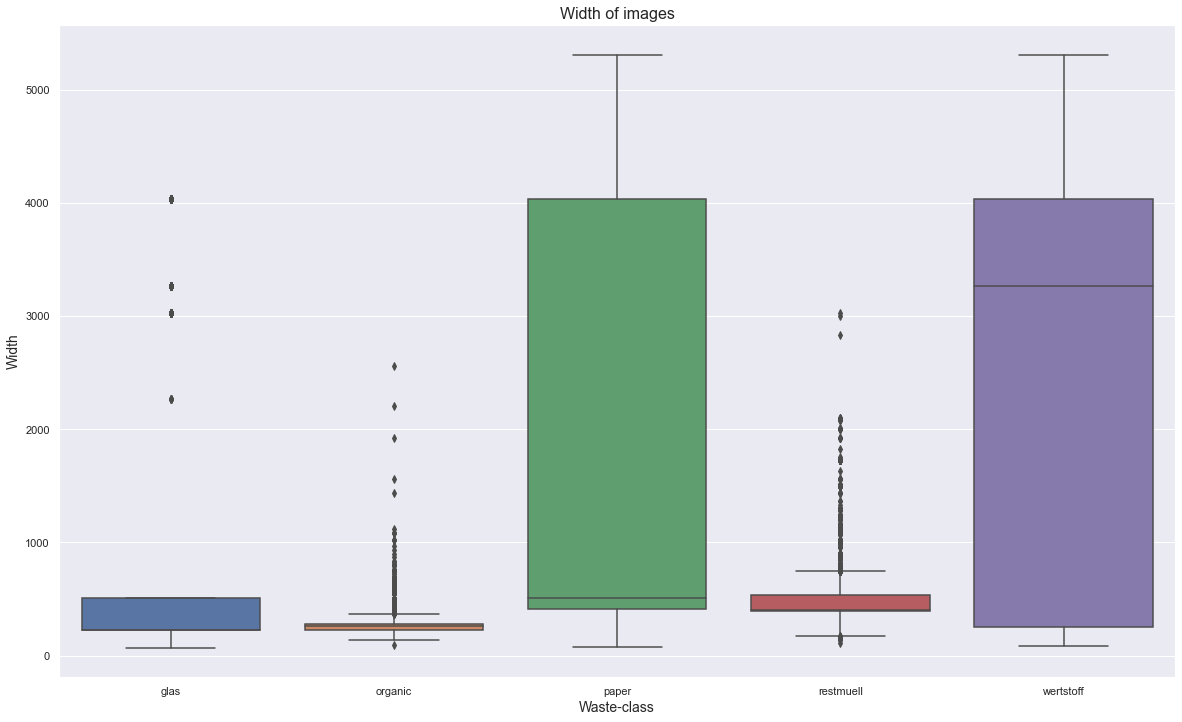

In [7]:
sns.set(rc={'figure.figsize':(20,12)})
boxplot = sns.boxplot(x=labels, y=width)
boxplot.axes.set_title("Width of images", fontsize=16)
boxplot.set_xlabel("Waste-class", fontsize=14)
boxplot.set_ylabel("Width", fontsize=14)
boxplot

<AxesSubplot:title={'center':'Height of images'}, xlabel='Waste-class', ylabel='Height'>

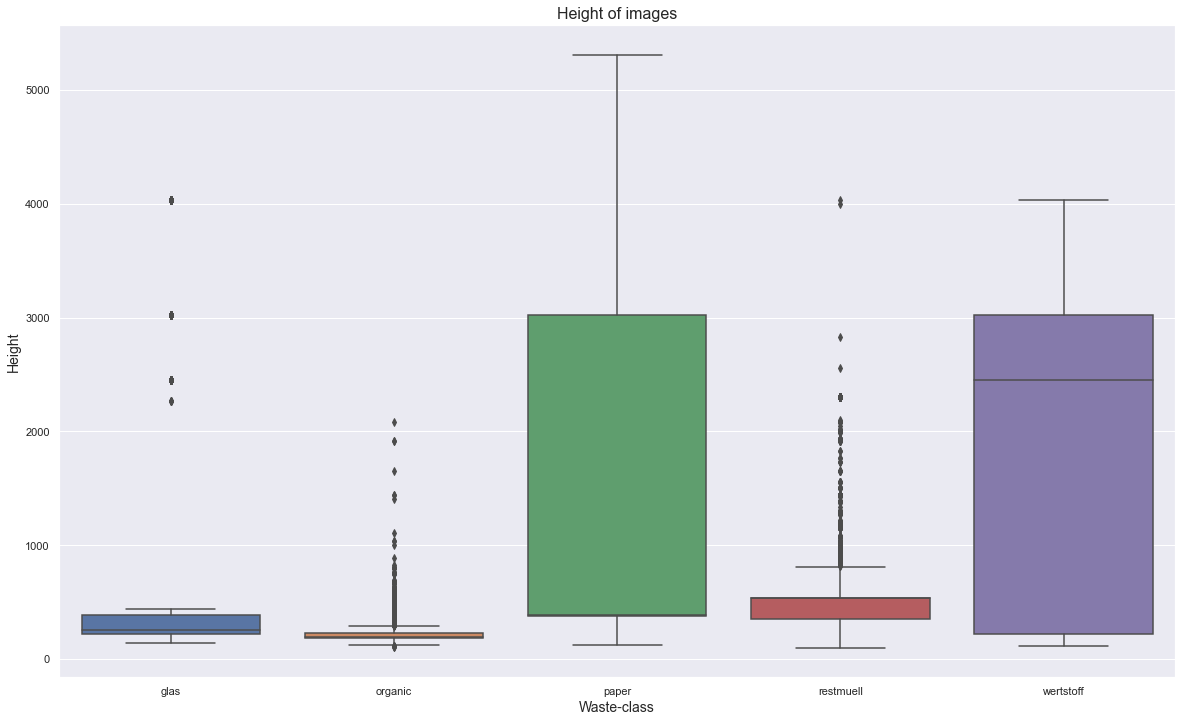

In [8]:
boxplot = sns.boxplot(x=labels, y=height)
boxplot.axes.set_title("Height of images", fontsize=16)
boxplot.set_xlabel("Waste-class", fontsize=14)
boxplot.set_ylabel("Height", fontsize=14)
boxplot

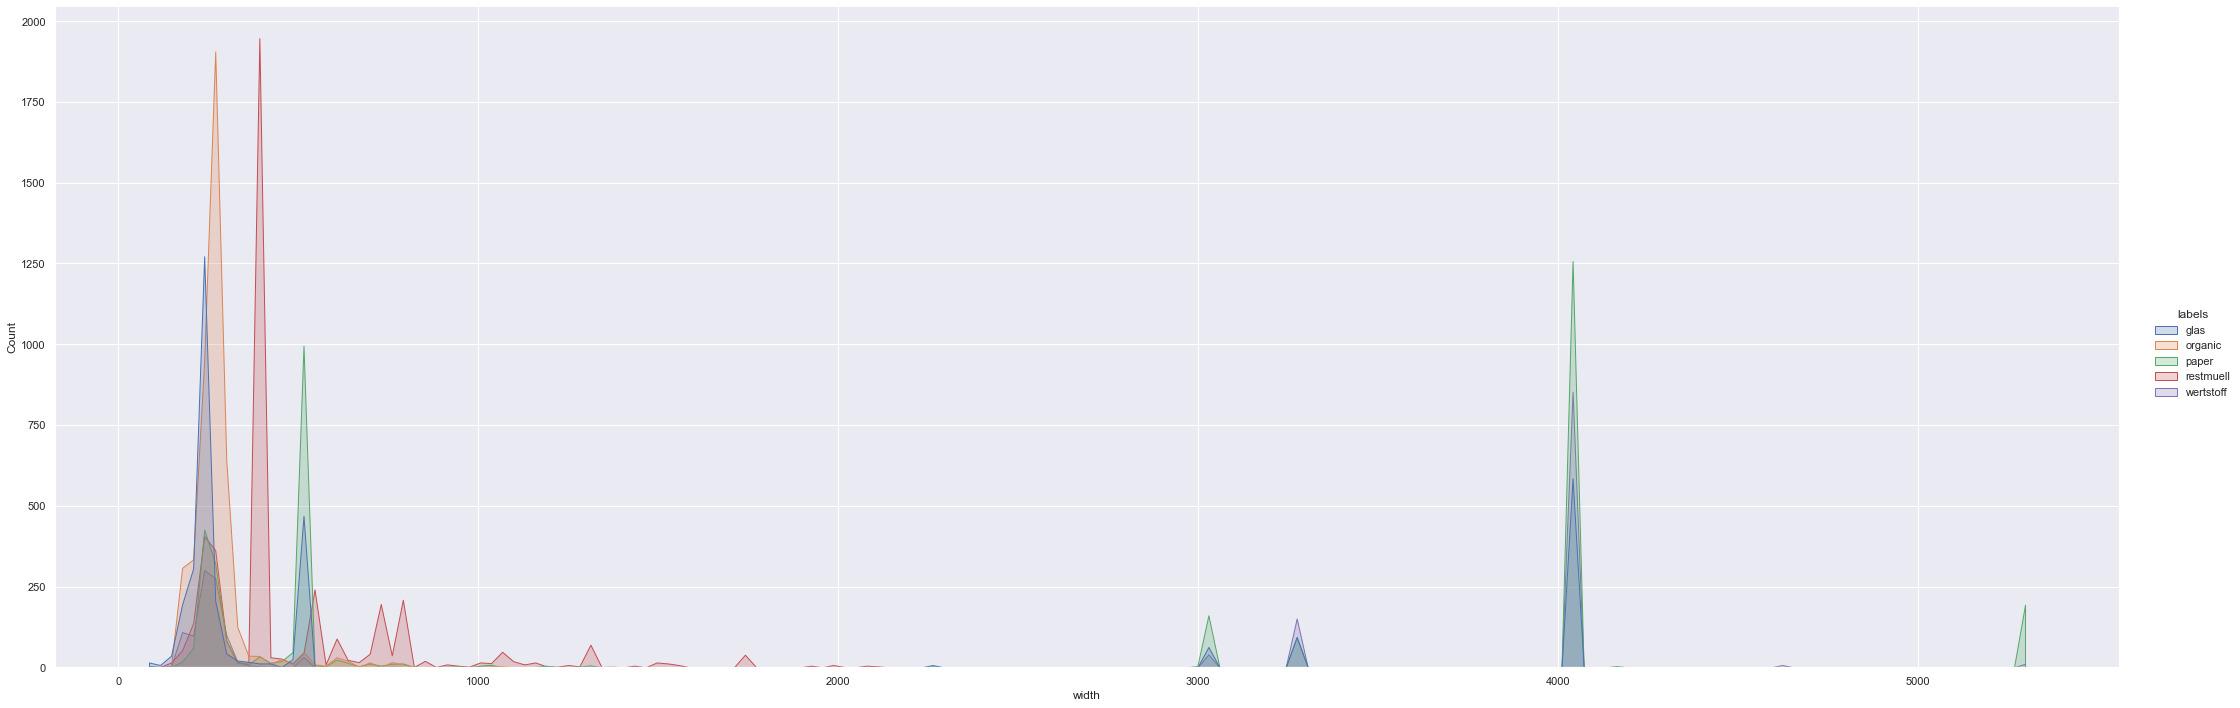

In [9]:
#data.drop(data[data.width > 4200].index, inplace=True)
sns.displot(data, x="width", hue='labels', aspect=3, height=10, element="poly")

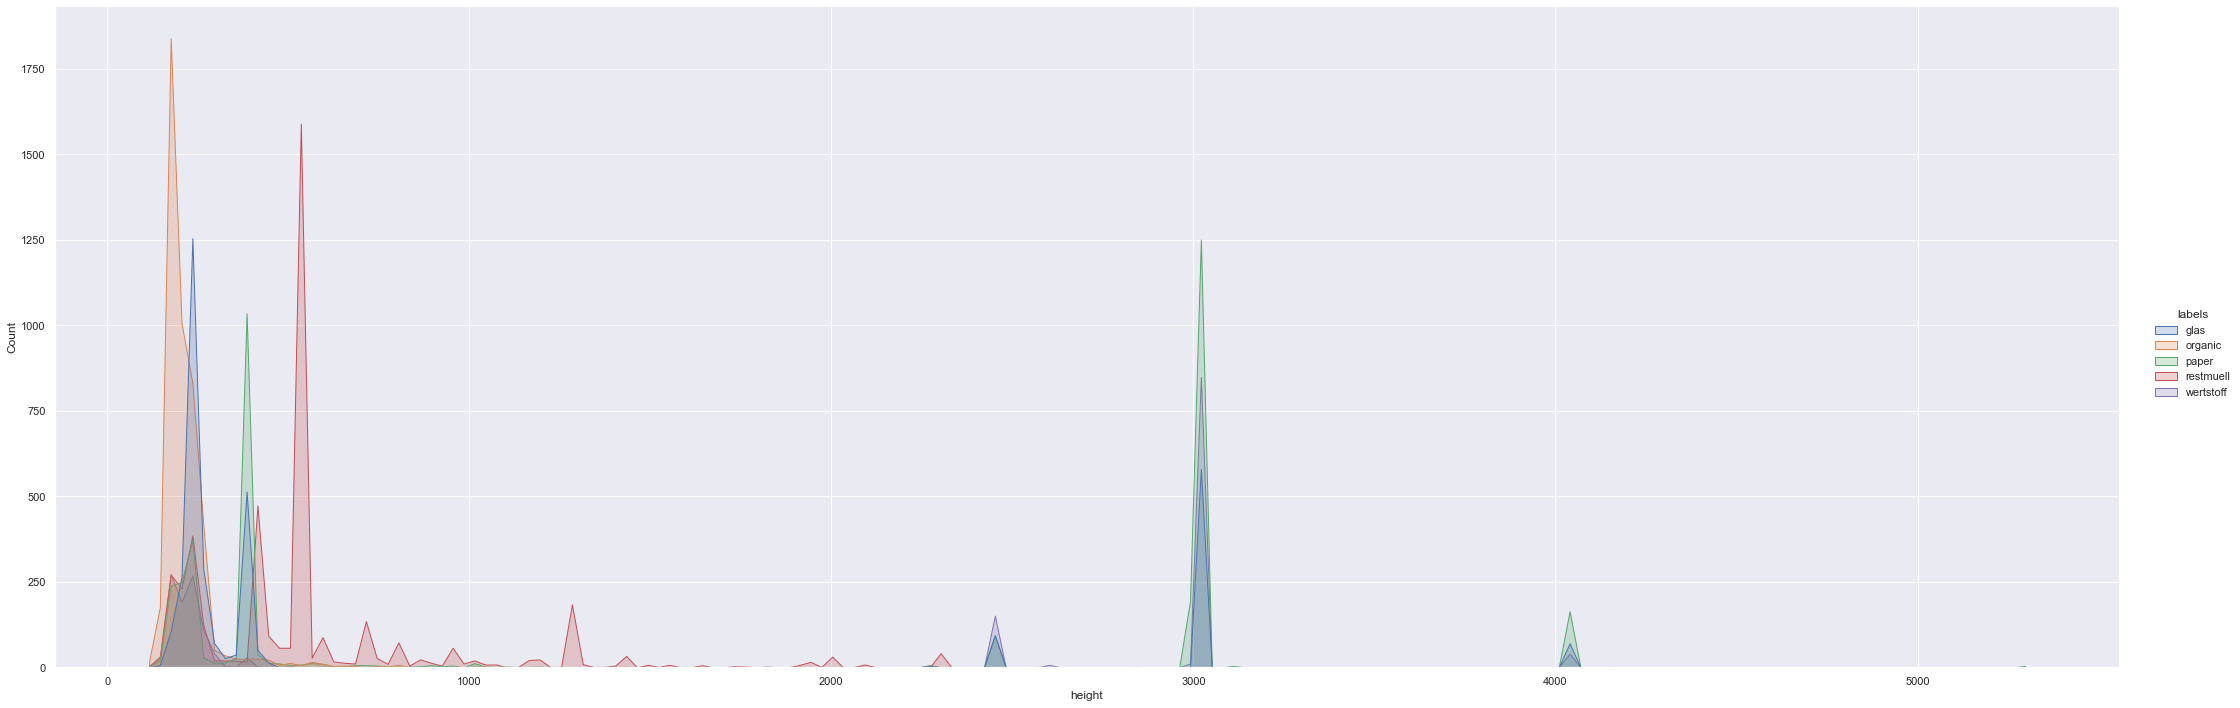

In [10]:
#data.drop(data[data.height > 4200].index, inplace=True)
sns.displot(data, x="height", hue='labels', aspect=3, height=10, element="poly")

In [11]:
data.shape

(18228, 5)

In [12]:
tr, val = train_test_split(data, stratify=data.labels, test_size=0.2)
tr.reset_index(drop=True)
val.reset_index(drop=True)
tr = tr.head(images_for_train)
val = val.head(images_for_train)

In [13]:
waste_types_df = tr[['encoded_labels', 'labels']].drop_duplicates().sort_values(by='encoded_labels').reset_index(drop=True)
garbage_types = {}
for i in range(0, len(waste_types_df)):
    garbage_types[i] = waste_types_df.iloc[i].labels
print(garbage_types)

{0: 'glas', 1: 'organic', 2: 'paper', 3: 'restmuell', 4: 'wertstoff'}


In [14]:
from torchvision import transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

In [15]:
from torch.utils.data import Dataset

class GarbageDataset(Dataset):
    def __init__(self, img_data, img_path, transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, index):
        img_name = os.path.join(self.img_path, self.img_data.iloc[index].labels, self.img_data.iloc[index].Images)
        image = Image.open(img_name).convert('RGB')
        image = image.resize((256, 256))
        label = torch.tensor(self.img_data.iloc[index].encoded_labels)
        if self.transform is not None:
            image = self.transform(image)
        return image, label, img_name

In [16]:
from torch.utils.data import DataLoader

train_dataset = GarbageDataset(tr, data_path, transform)
test_dataset = GarbageDataset(val, data_path, transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [17]:
import numpy as np

def img_display(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

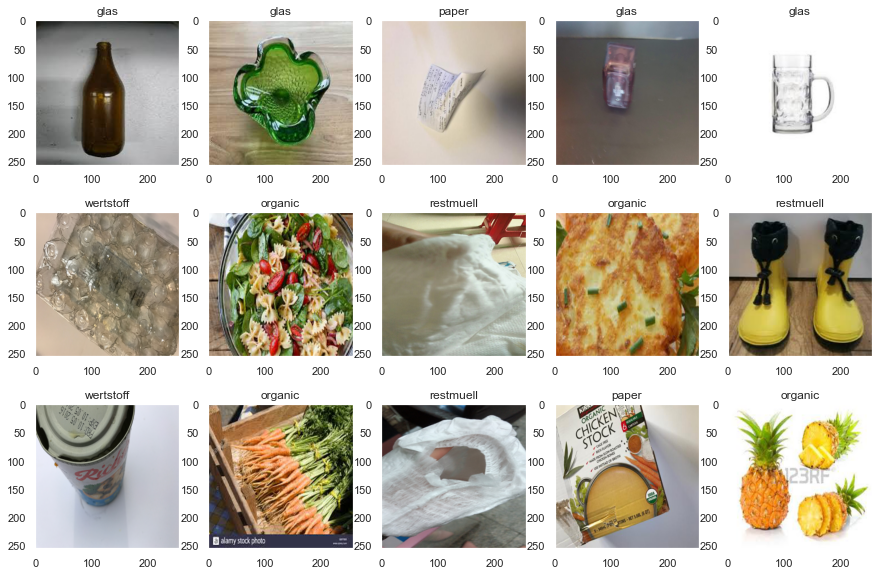

In [18]:
from matplotlib import pyplot as plt

# get some random training images
dataiter = iter(test_dataloader)
images, labels, _ = dataiter.next()
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.grid(None)
        ax.imshow(img_display(image))  # add image
        ax.set(title=f"{garbage_types[label.item()]}")  # add label